In [42]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret

In [43]:
# importar archivos csv
crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49003 entries, 0 to 49002
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   battleTime                             49003 non-null  object 
 1   playertag                              49003 non-null  object 
 2   event.id                               49003 non-null  int64  
 3   event.mode                             49003 non-null  object 
 4   event.map                              49003 non-null  object 
 5   battle.mode                            49003 non-null  object 
 6   battle.type                            49003 non-null  object 
 7   battle.result                          49003 non-null  object 
 8   battle.duration                        49003 non-null  float64
 9   battle.trophyChange                    35337 non-null  float64
 10  battle.starPlayer.tag                  40957 non-null  object 
 11  ba

In [44]:
# importar archivos csv
players = pd.read_csv('datasets/players/players.csv', index_col=0)
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81662 entries, 0 to 81661
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tag                                   81662 non-null  object 
 1   name                                  81661 non-null  object 
 2   nameColor                             79331 non-null  object 
 3   trophies                              81662 non-null  int64  
 4   highestTrophies                       81662 non-null  int64  
 5   highestPowerPlayPoints                59430 non-null  float64
 6   expLevel                              81662 non-null  int64  
 7   expPoints                             81662 non-null  int64  
 8   isQualifiedFromChampionshipChallenge  81662 non-null  bool   
 9   3vs3Victories                         81662 non-null  int64  
 10  soloVictories                         81662 non-null  int64  
 11  duoVictories   

In [45]:
# importar archivos csv
brawlers = pd.read_csv('datasets/brawlers/brawlers_stats.csv', index_col=0)
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      64 non-null     int64 
 1   name    64 non-null     object
 2   role    64 non-null     object
 3   range   64 non-null     object
 4   speed   64 non-null     object
 5   health  64 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.5+ KB


In [46]:
# crear columna playerteam
for i in range(len(crossBattlelog)):
	if any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team1.player1.tag'], crossBattlelog.loc[i, 'battle.team1.player2.tag'], crossBattlelog.loc[i, 'battle.team1.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team1'
	elif any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team2.player1.tag'], crossBattlelog.loc[i, 'battle.team2.player2.tag'], crossBattlelog.loc[i, 'battle.team2.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team2'
	else:
		print("error in team assignation for id " + str(i))

crossBattlelog['player_team'].value_counts()

team1    24503
team2    24500
Name: player_team, dtype: int64

In [47]:
# crear columna winner_team
for i in range(len(crossBattlelog)):
	if crossBattlelog.loc[i, 'battle.result'] == 'draw':
		crossBattlelog.loc[i, 'winner_team'] = 'draw'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	elif crossBattlelog.loc[i, 'player_team'] == 'team1' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'victory':
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	elif crossBattlelog.loc[i, 'player_team'] == 'team2' and crossBattlelog.loc[i, 'battle.result'] == 'defeat':
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	else:
		print("error in winner assignation for id " + str(i))

crossBattlelog['winner_team'].value_counts()

team1    24583
team2    24179
draw       241
Name: winner_team, dtype: int64

In [48]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['winner_team'] != 'draw'].reset_index(drop=True)

In [49]:
# agregar columna identificando batallas levelup y definir subset
for i in range(len(crossBattlelog)):

	t1p1 = crossBattlelog.loc[i, 'battle.team1.player1.brawler.trophies']
	t1p2 = crossBattlelog.loc[i, 'battle.team1.player2.brawler.trophies']
	t1p3 = crossBattlelog.loc[i, 'battle.team1.player3.brawler.trophies']
	t2p1 = crossBattlelog.loc[i, 'battle.team2.player1.brawler.trophies']
	t2p2 = crossBattlelog.loc[i, 'battle.team2.player2.brawler.trophies']
	t2p3 = crossBattlelog.loc[i, 'battle.team2.player3.brawler.trophies']

	if  (t1p1 <= 500 or t1p2 <= 500 or t1p3 <= 500 or t2p1 <= 500 or t2p2 <= 500 or t2p3 <= 500):
		crossBattlelog.loc[i, 'low_trophy'] = 'y'
	else:
		crossBattlelog.loc[i, 'low_trophy'] = 'n'

crossBattlelog = crossBattlelog[crossBattlelog['low_trophy'] == 'n']

crossBattlelog.shape

(30279, 66)

In [50]:
# agregar players
battlelogSet = crossBattlelog

def add_players(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='left', suffixes=('','_p'))
	return df

battlelogSet = add_players(battlelogSet, 'battle.team1.player1.')
battlelogSet = add_players(battlelogSet, 'battle.team1.player2.')
battlelogSet = add_players(battlelogSet, 'battle.team1.player3.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player1.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player2.')
battlelogSet = add_players(battlelogSet, 'battle.team2.player3.')

battlelogSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30279 entries, 0 to 30278
Columns: 168 entries, battleTime to battle.team2.player3.import_date
dtypes: float64(105), int64(1), object(62)
memory usage: 39.0+ MB


In [51]:
# agregar brawler stats
def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers.add_prefix(prefix), on=prefix + 'id', how='left', suffixes=('','_b'))
	return df

battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player1.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player2.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team1.player3.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player1.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player2.brawler.')
battlelogSet = add_brawlers(battlelogSet, 'battle.team2.player3.brawler.')

battlelogSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30279 entries, 0 to 30278
Columns: 198 entries, battleTime to battle.team2.player3.brawler.health
dtypes: float64(105), int64(7), object(86)
memory usage: 46.0+ MB


In [52]:
battlelogFinal = battlelogSet[[
	'battleTime'
	,'event.mode'
	,'event.map'
	,'battle.mode'
	,'battle.type'
	,'player_team'
	,'winner_team'
	,'battle.team1.player1.brawler.name'
	,'battle.team1.player1.brawler.power'
	,'battle.team1.player1.brawler.trophies'
	,'battle.team1.player1.trophies'
	,'battle.team1.player1.highestTrophies'
	,'battle.team1.player1.highestPowerPlayPoints'
	,'battle.team1.player1.expLevel'
	,'battle.team1.player1.expPoints'
	,'battle.team1.player1.3vs3Victories'
	,'battle.team1.player1.soloVictories'
	,'battle.team1.player1.duoVictories'
	,'battle.team1.player1.brawler.role'
	,'battle.team1.player1.brawler.range'
	,'battle.team1.player1.brawler.speed'
	,'battle.team1.player1.brawler.health'
	,'battle.team1.player2.brawler.name'
	,'battle.team1.player2.brawler.power'
	,'battle.team1.player2.brawler.trophies'
	,'battle.team1.player2.trophies'
	,'battle.team1.player2.highestTrophies'
	,'battle.team1.player2.highestPowerPlayPoints'
	,'battle.team1.player2.expLevel'
	,'battle.team1.player2.expPoints'
	,'battle.team1.player2.3vs3Victories'
	,'battle.team1.player2.soloVictories'
	,'battle.team1.player2.duoVictories'
	,'battle.team1.player2.brawler.role'
	,'battle.team1.player2.brawler.range'
	,'battle.team1.player2.brawler.speed'
	,'battle.team1.player2.brawler.health'
	,'battle.team1.player3.brawler.name'
	,'battle.team1.player3.brawler.power'
	,'battle.team1.player3.brawler.trophies'
	,'battle.team1.player3.trophies'
	,'battle.team1.player3.highestTrophies'
	,'battle.team1.player3.highestPowerPlayPoints'
	,'battle.team1.player3.expLevel'
	,'battle.team1.player3.expPoints'
	,'battle.team1.player3.3vs3Victories'
	,'battle.team1.player3.soloVictories'
	,'battle.team1.player3.duoVictories'
	,'battle.team1.player3.brawler.role'
	,'battle.team1.player3.brawler.range'
	,'battle.team1.player3.brawler.speed'
	,'battle.team1.player3.brawler.health'
	,'battle.team2.player1.brawler.name'
	,'battle.team2.player1.brawler.power'
	,'battle.team2.player1.brawler.trophies'
	,'battle.team2.player1.trophies'
	,'battle.team2.player1.highestTrophies'
	,'battle.team2.player1.highestPowerPlayPoints'
	,'battle.team2.player1.expLevel'
	,'battle.team2.player1.expPoints'
	,'battle.team2.player1.3vs3Victories'
	,'battle.team2.player1.soloVictories'
	,'battle.team2.player1.duoVictories'
	,'battle.team2.player1.brawler.role'
	,'battle.team2.player1.brawler.range'
	,'battle.team2.player1.brawler.speed'
	,'battle.team2.player1.brawler.health'
	,'battle.team2.player2.brawler.name'
	,'battle.team2.player2.brawler.power'
	,'battle.team2.player2.brawler.trophies'
	,'battle.team2.player2.trophies'
	,'battle.team2.player2.highestTrophies'
	,'battle.team2.player2.highestPowerPlayPoints'
	,'battle.team2.player2.expLevel'
	,'battle.team2.player2.expPoints'
	,'battle.team2.player2.3vs3Victories'
	,'battle.team2.player2.soloVictories'
	,'battle.team2.player2.duoVictories'
	,'battle.team2.player2.brawler.role'
	,'battle.team2.player2.brawler.range'
	,'battle.team2.player2.brawler.speed'
	,'battle.team2.player2.brawler.health'
	,'battle.team2.player3.brawler.name'
	,'battle.team2.player3.brawler.power'
	,'battle.team2.player3.brawler.trophies'
	,'battle.team2.player3.trophies'
	,'battle.team2.player3.highestTrophies'
	,'battle.team2.player3.highestPowerPlayPoints'
	,'battle.team2.player3.expLevel'
	,'battle.team2.player3.expPoints'
	,'battle.team2.player3.3vs3Victories'
	,'battle.team2.player3.soloVictories'
	,'battle.team2.player3.duoVictories'
	,'battle.team2.player3.brawler.role'
	,'battle.team2.player3.brawler.range'
	,'battle.team2.player3.brawler.speed'
	,'battle.team2.player3.brawler.health'
]]

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30279 entries, 0 to 30278
Data columns (total 97 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   battleTime                                   30279 non-null  object 
 1   event.mode                                   30279 non-null  object 
 2   event.map                                    30279 non-null  object 
 3   battle.mode                                  30279 non-null  object 
 4   battle.type                                  30279 non-null  object 
 5   player_team                                  30279 non-null  object 
 6   winner_team                                  30279 non-null  object 
 7   battle.team1.player1.brawler.name            30279 non-null  object 
 8   battle.team1.player1.brawler.power           30279 non-null  float64
 9   battle.team1.player1.brawler.trophies        30279 non-null  float64
 10

In [53]:
# format date
for i, battleTime in enumerate(battlelogFinal['battleTime']):	
	battlelogFinal.loc[i, 'battleTime'] = pd.to_datetime(battlelogFinal.loc[i, 'battleTime'])
battlelogFinal['battleTime']

0        2023-01-15 23:52:17+00:00
1        2023-01-15 23:46:38+00:00
2        2023-01-15 23:41:45+00:00
3        2023-01-15 23:35:49+00:00
4        2023-01-15 23:30:59+00:00
                   ...            
30274    2022-12-31 15:14:10+00:00
30275    2023-01-02 04:18:29+00:00
30276    2023-01-02 04:05:44+00:00
30277    2023-01-01 16:35:13+00:00
30278    2023-01-02 02:19:30+00:00
Name: battleTime, Length: 30279, dtype: object

In [54]:
# crear columna winner
def clean_winner(team):

	df = battlelogFinal[battlelogFinal['player_team'] == team].reset_index(drop = True)

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			winner = 'y'
		else:
			winner = 'n'
		
		df.loc[i, 'winner'] = winner

	df = df.drop('winner_team', axis=1)

	df = df.rename(columns={
		'battle.' + team + '.player1.brawler.name': 'battle.player1.brawler.name'
		,'battle.' + team + '.player1.brawler.power': 'battle.player1.brawler.power'
		,'battle.' + team + '.player1.brawler.trophies': 'battle.player1.brawler.trophies'
		,'battle.' + team + '.player1.trophies': 'battle.player1.trophies'
		,'battle.' + team + '.player1.highestTrophies': 'battle.player1.highestTrophies'
		,'battle.' + team + '.player1.highestPowerPlayPoints': 'battle.player1.highestPowerPlayPoints'
		,'battle.' + team + '.player1.expLevel': 'battle.player1.expLevel'
		,'battle.' + team + '.player1.expPoints': 'battle.player1.expPoints'
		,'battle.' + team + '.player1.3vs3Victories': 'battle.player1.3vs3Victories'
		,'battle.' + team + '.player1.soloVictories': 'battle.player1.soloVictories'
		,'battle.' + team + '.player1.duoVictories': 'battle.player1.duoVictories'
		,'battle.' + team + '.player1.brawler.role': 'battle.player1.brawler.role'
		,'battle.' + team + '.player1.brawler.range': 'battle.player1.brawler.range'
		,'battle.' + team + '.player1.brawler.speed': 'battle.player1.brawler.speed'
		,'battle.' + team + '.player1.brawler.health': 'battle.player1.brawler.health'
		,'battle.' + team + '.player2.brawler.name': 'battle.player2.brawler.name'
		,'battle.' + team + '.player2.brawler.power': 'battle.player2.brawler.power'
		,'battle.' + team + '.player2.brawler.trophies': 'battle.player2.brawler.trophies'
		,'battle.' + team + '.player2.trophies': 'battle.player2.trophies'
		,'battle.' + team + '.player2.highestTrophies': 'battle.player2.highestTrophies'
		,'battle.' + team + '.player2.highestPowerPlayPoints': 'battle.player2.highestPowerPlayPoints'
		,'battle.' + team + '.player2.expLevel': 'battle.player2.expLevel'
		,'battle.' + team + '.player2.expPoints': 'battle.player2.expPoints'
		,'battle.' + team + '.player2.3vs3Victories': 'battle.player2.3vs3Victories'
		,'battle.' + team + '.player2.soloVictories': 'battle.player2.soloVictories'
		,'battle.' + team + '.player2.duoVictories': 'battle.player2.duoVictories'
		,'battle.' + team + '.player2.brawler.role': 'battle.player2.brawler.role'
		,'battle.' + team + '.player2.brawler.range': 'battle.player2.brawler.range'
		,'battle.' + team + '.player2.brawler.speed': 'battle.player2.brawler.speed'
		,'battle.' + team + '.player2.brawler.health': 'battle.player2.brawler.health'
		,'battle.' + team + '.player3.brawler.name': 'battle.player3.brawler.name'
		,'battle.' + team + '.player3.brawler.power': 'battle.player3.brawler.power'
		,'battle.' + team + '.player3.brawler.trophies': 'battle.player3.brawler.trophies'
		,'battle.' + team + '.player3.trophies': 'battle.player3.trophies'
		,'battle.' + team + '.player3.highestTrophies': 'battle.player3.highestTrophies'
		,'battle.' + team + '.player3.highestPowerPlayPoints': 'battle.player3.highestPowerPlayPoints'
		,'battle.' + team + '.player3.expLevel': 'battle.player3.expLevel'
		,'battle.' + team + '.player3.expPoints': 'battle.player3.expPoints'
		,'battle.' + team + '.player3.3vs3Victories': 'battle.player3.3vs3Victories'
		,'battle.' + team + '.player3.soloVictories': 'battle.player3.soloVictories'
		,'battle.' + team + '.player3.duoVictories': 'battle.player3.duoVictories'
		,'battle.' + team + '.player3.brawler.role': 'battle.player3.brawler.role'
		,'battle.' + team + '.player3.brawler.range': 'battle.player3.brawler.range'
		,'battle.' + team + '.player3.brawler.speed': 'battle.player3.brawler.speed'
		,'battle.' + team + '.player3.brawler.health': 'battle.player3.brawler.health'
	})

	df = df[[	
		'event.mode'
		,'event.map'
		,'battle.mode'
		,'battle.type'
		,'battle.player1.brawler.name'
		,'battle.player1.brawler.power'
		,'battle.player1.brawler.trophies'
		,'battle.player1.trophies'
		,'battle.player1.highestTrophies'
		,'battle.player1.highestPowerPlayPoints'
		,'battle.player1.expLevel'
		,'battle.player1.expPoints'
		,'battle.player1.3vs3Victories'
		,'battle.player1.soloVictories'
		,'battle.player1.duoVictories'
		,'battle.player1.brawler.role'
		,'battle.player1.brawler.range'
		,'battle.player1.brawler.speed'
		,'battle.player1.brawler.health'
		,'battle.player2.brawler.name'
		,'battle.player2.brawler.power'
		,'battle.player2.brawler.trophies'
		,'battle.player2.trophies'
		,'battle.player2.highestTrophies'
		,'battle.player2.highestPowerPlayPoints'
		,'battle.player2.expLevel'
		,'battle.player2.expPoints'
		,'battle.player2.3vs3Victories'
		,'battle.player2.soloVictories'
		,'battle.player2.duoVictories'
		,'battle.player2.brawler.role'
		,'battle.player2.brawler.range'
		,'battle.player2.brawler.speed'
		,'battle.player2.brawler.health'
		,'battle.player3.brawler.name'
		,'battle.player3.brawler.power'
		,'battle.player3.brawler.trophies'
		,'battle.player3.trophies'
		,'battle.player3.highestTrophies'
		,'battle.player3.highestPowerPlayPoints'
		,'battle.player3.expLevel'
		,'battle.player3.expPoints'
		,'battle.player3.3vs3Victories'
		,'battle.player3.soloVictories'
		,'battle.player3.duoVictories'
		,'battle.player3.brawler.role'
		,'battle.player3.brawler.range'
		,'battle.player3.brawler.speed'
		,'battle.player3.brawler.health'
		,'winner'
	]]

	return df

def clean_loser(team):

	df = battlelogFinal[battlelogFinal['player_team'] == team].reset_index(drop = True)

	if team == 'team1':
		oteam = 'team2'
	else:
		oteam = 'team1'

	for i, winner_team in enumerate(df['winner_team']):
		if winner_team == team:
			winner = 'n'
		else:
			winner = 'y'
		
		df.loc[i, 'winner'] = winner

	df = df.drop('winner_team', axis=1)

	df = df.rename(columns={
		'battle.' + oteam + '.player1.brawler.name': 'battle.player1.brawler.name'
		,'battle.' + oteam + '.player1.brawler.power': 'battle.player1.brawler.power'
		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.player1.brawler.trophies'
		,'battle.' + oteam + '.player1.trophies': 'battle.player1.trophies'
		,'battle.' + oteam + '.player1.highestTrophies': 'battle.player1.highestTrophies'
		,'battle.' + oteam + '.player1.highestPowerPlayPoints': 'battle.player1.highestPowerPlayPoints'
		,'battle.' + oteam + '.player1.expLevel': 'battle.player1.expLevel'
		,'battle.' + oteam + '.player1.expPoints': 'battle.player1.expPoints'
		,'battle.' + oteam + '.player1.3vs3Victories': 'battle.player1.3vs3Victories'
		,'battle.' + oteam + '.player1.soloVictories': 'battle.player1.soloVictories'
		,'battle.' + oteam + '.player1.duoVictories': 'battle.player1.duoVictories'
		,'battle.' + oteam + '.player1.brawler.role': 'battle.player1.brawler.role'
		,'battle.' + oteam + '.player1.brawler.range': 'battle.player1.brawler.range'
		,'battle.' + oteam + '.player1.brawler.speed': 'battle.player1.brawler.speed'
		,'battle.' + oteam + '.player1.brawler.health': 'battle.player1.brawler.health'
		,'battle.' + oteam + '.player2.brawler.name': 'battle.player2.brawler.name'
		,'battle.' + oteam + '.player2.brawler.power': 'battle.player2.brawler.power'
		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.player2.brawler.trophies'
		,'battle.' + oteam + '.player2.trophies': 'battle.player2.trophies'
		,'battle.' + oteam + '.player2.highestTrophies': 'battle.player2.highestTrophies'
		,'battle.' + oteam + '.player2.highestPowerPlayPoints': 'battle.player2.highestPowerPlayPoints'
		,'battle.' + oteam + '.player2.expLevel': 'battle.player2.expLevel'
		,'battle.' + oteam + '.player2.expPoints': 'battle.player2.expPoints'
		,'battle.' + oteam + '.player2.3vs3Victories': 'battle.player2.3vs3Victories'
		,'battle.' + oteam + '.player2.soloVictories': 'battle.player2.soloVictories'
		,'battle.' + oteam + '.player2.duoVictories': 'battle.player2.duoVictories'
		,'battle.' + oteam + '.player2.brawler.role': 'battle.player2.brawler.role'
		,'battle.' + oteam + '.player2.brawler.range': 'battle.player2.brawler.range'
		,'battle.' + oteam + '.player2.brawler.speed': 'battle.player2.brawler.speed'
		,'battle.' + oteam + '.player2.brawler.health': 'battle.player2.brawler.health'
		,'battle.' + oteam + '.player3.brawler.name': 'battle.player3.brawler.name'
		,'battle.' + oteam + '.player3.brawler.power': 'battle.player3.brawler.power'
		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.player3.brawler.trophies'
		,'battle.' + oteam + '.player3.trophies': 'battle.player3.trophies'
		,'battle.' + oteam + '.player3.highestTrophies': 'battle.player3.highestTrophies'
		,'battle.' + oteam + '.player3.highestPowerPlayPoints': 'battle.player3.highestPowerPlayPoints'
		,'battle.' + oteam + '.player3.expLevel': 'battle.player3.expLevel'
		,'battle.' + oteam + '.player3.expPoints': 'battle.player3.expPoints'
		,'battle.' + oteam + '.player3.3vs3Victories': 'battle.player3.3vs3Victories'
		,'battle.' + oteam + '.player3.soloVictories': 'battle.player3.soloVictories'
		,'battle.' + oteam + '.player3.duoVictories': 'battle.player3.duoVictories'
		,'battle.' + oteam + '.player3.brawler.role': 'battle.player3.brawler.role'
		,'battle.' + oteam + '.player3.brawler.range': 'battle.player3.brawler.range'
		,'battle.' + oteam + '.player3.brawler.speed': 'battle.player3.brawler.speed'
		,'battle.' + oteam + '.player3.brawler.health': 'battle.player3.brawler.health'
	})

	df = df[[	
		'event.mode'
		,'event.map'
		,'battle.mode'
		,'battle.type'
		,'battle.player1.brawler.name'
		,'battle.player1.brawler.power'
		,'battle.player1.brawler.trophies'
		,'battle.player1.trophies'
		,'battle.player1.highestTrophies'
		,'battle.player1.highestPowerPlayPoints'
		,'battle.player1.expLevel'
		,'battle.player1.expPoints'
		,'battle.player1.3vs3Victories'
		,'battle.player1.soloVictories'
		,'battle.player1.duoVictories'
		,'battle.player1.brawler.role'
		,'battle.player1.brawler.range'
		,'battle.player1.brawler.speed'
		,'battle.player1.brawler.health'
		,'battle.player2.brawler.name'
		,'battle.player2.brawler.power'
		,'battle.player2.brawler.trophies'
		,'battle.player2.trophies'
		,'battle.player2.highestTrophies'
		,'battle.player2.highestPowerPlayPoints'
		,'battle.player2.expLevel'
		,'battle.player2.expPoints'
		,'battle.player2.3vs3Victories'
		,'battle.player2.soloVictories'
		,'battle.player2.duoVictories'
		,'battle.player2.brawler.role'
		,'battle.player2.brawler.range'
		,'battle.player2.brawler.speed'
		,'battle.player2.brawler.health'
		,'battle.player3.brawler.name'
		,'battle.player3.brawler.power'
		,'battle.player3.brawler.trophies'
		,'battle.player3.trophies'
		,'battle.player3.highestTrophies'
		,'battle.player3.highestPowerPlayPoints'
		,'battle.player3.expLevel'
		,'battle.player3.expPoints'
		,'battle.player3.3vs3Victories'
		,'battle.player3.soloVictories'
		,'battle.player3.duoVictories'
		,'battle.player3.brawler.role'
		,'battle.player3.brawler.range'
		,'battle.player3.brawler.speed'
		,'battle.player3.brawler.health'
		,'winner'
	]]

	return df

team1 = clean_winner('team1')
team2 = clean_winner('team2')
oteam1 = clean_loser('team1')
oteam2 = clean_loser('team2')

battlelogProcess = pd.concat([team1, team2, oteam1, oteam2], ignore_index=True).reset_index(drop = True)
battlelogProcess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60558 entries, 0 to 60557
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   event.mode                             60558 non-null  object 
 1   event.map                              60558 non-null  object 
 2   battle.mode                            60558 non-null  object 
 3   battle.type                            60558 non-null  object 
 4   battle.player1.brawler.name            60558 non-null  object 
 5   battle.player1.brawler.power           60558 non-null  float64
 6   battle.player1.brawler.trophies        60558 non-null  float64
 7   battle.player1.trophies                60519 non-null  float64
 8   battle.player1.highestTrophies         60519 non-null  float64
 9   battle.player1.highestPowerPlayPoints  51216 non-null  float64
 10  battle.player1.expLevel                60519 non-null  float64
 11  ba

In [55]:
battlelogProcess['winner'].value_counts()

y    30279
n    30279
Name: winner, dtype: int64

In [56]:
battlelogProcess = battlelogProcess[[	
	'event.mode'
	,'event.map'
	,'battle.mode'
	,'battle.type'
	,'battle.player1.brawler.name'
	,'battle.player1.brawler.power'
	,'battle.player1.brawler.trophies'
	,'battle.player1.trophies'
	#,'battle.player1.highestTrophies'
	#,'battle.player1.highestPowerPlayPoints'
	#,'battle.player1.expLevel'
	#,'battle.player1.expPoints'
	#,'battle.player1.3vs3Victories'
	#,'battle.player1.soloVictories'
	#,'battle.player1.duoVictories'
	,'battle.player1.brawler.role'
	,'battle.player1.brawler.range'
	,'battle.player1.brawler.speed'
	,'battle.player1.brawler.health'
	,'battle.player2.brawler.name'
	,'battle.player2.brawler.power'
	,'battle.player2.brawler.trophies'
	,'battle.player2.trophies'
	#,'battle.player2.highestTrophies'
	#,'battle.player2.highestPowerPlayPoints'
	#,'battle.player2.expLevel'
	#,'battle.player2.expPoints'
	#,'battle.player2.3vs3Victories'
	#,'battle.player2.soloVictories'
	#,'battle.player2.duoVictories'
	,'battle.player2.brawler.role'
	,'battle.player2.brawler.range'
	,'battle.player2.brawler.speed'
	,'battle.player2.brawler.health'
	,'battle.player3.brawler.name'
	,'battle.player3.brawler.power'
	,'battle.player3.brawler.trophies'
	,'battle.player3.trophies'
	#,'battle.player3.highestTrophies'
	#,'battle.player3.highestPowerPlayPoints'
	#,'battle.player3.expLevel'
	#,'battle.player3.expPoints'
	#,'battle.player3.3vs3Victories'
	#,'battle.player3.soloVictories'
	#,'battle.player3.duoVictories'
	,'battle.player3.brawler.role'
	,'battle.player3.brawler.range'
	,'battle.player3.brawler.speed'
	,'battle.player3.brawler.health'
	,'winner'
]]

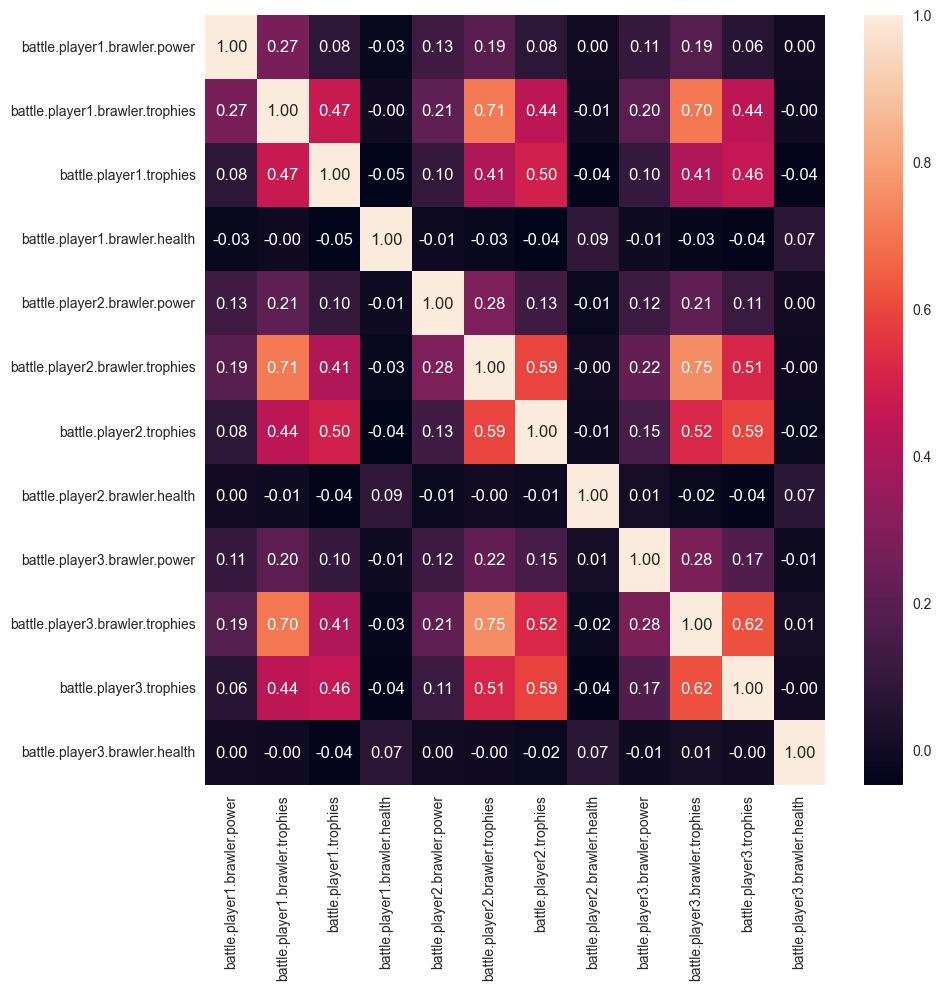

In [57]:
#mapa de correlacion
plt.figure(figsize=(10, 10))

sns.heatmap(battlelogProcess.corr(), annot=True, fmt=".2f")
plt.show()

In [58]:
# generar set de testing y training
seed=14644

from sklearn.model_selection import train_test_split
train, test = train_test_split(battlelogProcess, test_size = 0.7, random_state=42, stratify=battlelogProcess['winner'])
train.shape

(18167, 29)

In [59]:
from pycaret.classification import *

session_1 = setup(
	data = train, 
	target = 'winner', 
	fix_imbalance = True,
    feature_selection= True,
    use_gpu=True)

,Description,Value
0,session_id,3260
1,Target,winner
2,Target Type,Binary
3,Label Encoded,"n: 0, y: 1"
4,Original Data,"(18167, 29)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


In [60]:
#comparación de modelos
models = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7730,0.8324,0.8025,0.7559,0.7784,0.5461,0.5473,19.1440
lightgbm,Light Gradient Boosting Machine,0.7714,0.8283,0.7894,0.7601,0.7744,0.5429,0.5434,5.9220
ada,Ada Boost Classifier,0.7597,0.8226,0.7474,0.7641,0.7555,0.5193,0.5196,7.0490
rf,Random Forest Classifier,0.7528,0.8180,0.7528,0.7507,0.7517,0.5057,0.5058,7.4360
ridge,Ridge Classifier,0.7431,0.0000,0.7773,0.7255,0.7504,0.4864,0.4878,3.5370
lda,Linear Discriminant Analysis,0.7426,0.8068,0.7770,0.7250,0.7500,0.4854,0.4869,4.7070
nb,Naive Bayes,0.7376,0.8062,0.7838,0.7155,0.7479,0.4754,0.4779,3.6170
et,Extra Trees Classifier,0.7447,0.7906,0.7257,0.7520,0.7386,0.4892,0.4896,10.0220
knn,K Neighbors Classifier,0.7325,0.7760,0.7441,0.7251,0.7343,0.4652,0.4655,7.3080
lr,Logistic Regression,0.7166,0.7754,0.7739,0.6935,0.7310,0.4336,0.4371,5.6590


In [61]:
# creando modelos para el estimador escogido 
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7649,0.8242,0.7832,0.7534,0.7680,0.5300,0.5304
1,0.7862,0.8363,0.8054,0.7736,0.7891,0.5724,0.5729
2,0.7704,0.8276,0.7816,0.7623,0.7719,0.5409,0.5411
3,0.7665,0.8280,0.8070,0.7445,0.7745,0.5332,0.5351
4,0.7704,0.8213,0.7864,0.7599,0.7729,0.5410,0.5413
5,0.7626,0.8254,0.7911,0.7463,0.7680,0.5253,0.5263
6,0.7663,0.8272,0.7829,0.7554,0.7689,0.5327,0.5331
7,0.7710,0.8225,0.7753,0.7668,0.7710,0.5421,0.5421
8,0.7703,0.8273,0.7991,0.7537,0.7757,0.5407,0.5416


In [62]:
# tunear el modelo
lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7689,0.8215,0.7975,0.7522,0.7742,0.5379,0.5389
1,0.7649,0.8347,0.8006,0.7452,0.7719,0.5301,0.5315
2,0.7720,0.8288,0.7991,0.7560,0.7769,0.5442,0.5450
3,0.7689,0.8392,0.8149,0.7442,0.7779,0.5380,0.5404
4,0.7704,0.8228,0.7927,0.7568,0.7743,0.5410,0.5416
5,0.7767,0.8346,0.8180,0.7536,0.7845,0.5537,0.5557
6,0.7703,0.8354,0.8019,0.7519,0.7761,0.5407,0.5419
7,0.7679,0.8230,0.7753,0.7621,0.7686,0.5358,0.5359
8,0.7750,0.8289,0.8085,0.7559,0.7813,0.5501,0.5514


In [63]:
#finalizar modelo
model = finalize_model(lightgbm)
predictions = predict_model(model, data = test, raw_score=True)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0,0.8266,0,0,0,0,0


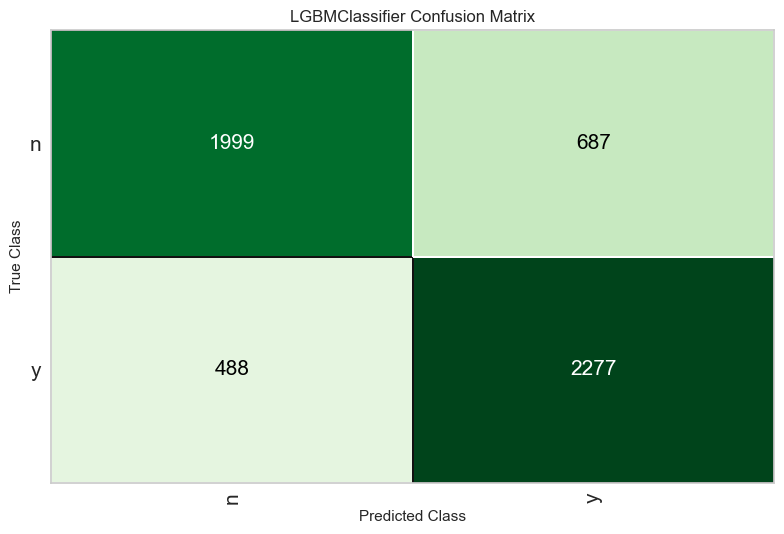

In [64]:
plot_model(model, plot='confusion_matrix')

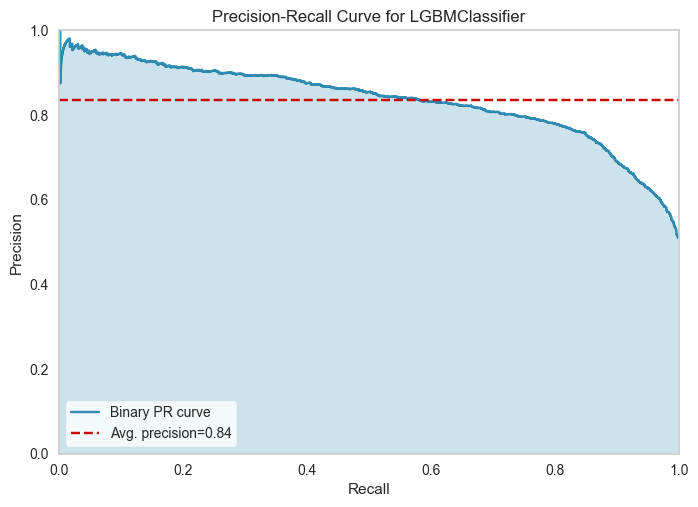

In [65]:
plot_model(model, 'pr')

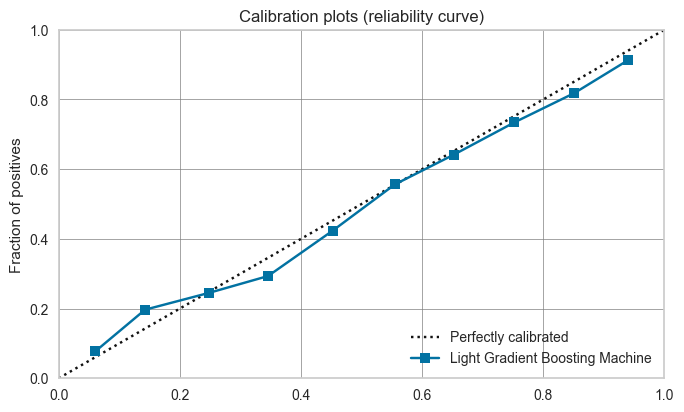

In [66]:
plot_model(model, 'calibration')

In [67]:
print(model)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, device='gpu',
               feature_fraction=0.5, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=16,
               min_child_weight=0.001, min_split_gain=0.3, n_estimators=50,
               n_jobs=-1, num_leaves=20, objective=None, random_state=3260,
               reg_alpha=0.0001, reg_lambda=0.001, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [68]:
save_model(model, 'models/lightgbm_less_columns')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='winner',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                 colsample_bytree=1.0, device='gpu',
                                 feature_fraction=0.5, importance_type='split',
                                 learning_rate=0.05, max_depth=-1,
                                 min_child_samples=16, min

In [70]:
predictions.to_csv('datasets/predictions/predictions_lc.csv')